In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import os
import seaborn as sns
import matplotlib.patches as patches


In [4]:
path = '/Users/alexandernizov/Desktop/UECFOOD256'
categories = 'category.txt'
bbox_files = 'bb_info.txt'
imgs_format = 'jpg'

In [8]:
category_ids = []
category_names = []

with open(path + '/' + categories, 'r') as list_:
    next(list_)
    for line in list_:
        line = line.rstrip('\n').split('\t')
        category_ids.append(int(line[0]))
        category_names.append(line[1])

print(category_ids[0:5])
print(category_names[0:5])

[1, 2, 3, 4, 5]
['rice', 'eels on rice', 'pilaf', "chicken-'n'-egg on rice", 'pork cutlet on rice']


In [13]:
categories_images = []
categories_bbox_info = []

for id_pos, id in enumerate(category_ids):
    categories_images.append([])
    categories_bbox_info.append([])

    imgs_file_list = path + '/' + str(id) + '/' + bbox_files

    with open(imgs_file_list, 'r') as list_:
        next(list_)
        for line in list_:
            line = line.rstrip('\n').split(' ')
            categories_images[id_pos].append(line[0])
            line = line[1:]

            for j, l in enumerate(line):
                line[j] = float(l)
            categories_bbox_info[id_pos].append(line)

print(categories_images[0][0:10])
print(categories_bbox_info[0][0:10])

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
[[0.0, 143.0, 370.0, 486.0], [20.0, 208.0, 582.0, 559.0], [2.0, 110.0, 243.0, 410.0], [0.0, 237.0, 286.0, 536.0], [8.0, 28.0, 761.0, 585.0], [0.0, 38.0, 369.0, 310.0], [0.0, 162.0, 383.0, 450.0], [80.0, 31.0, 776.0, 454.0], [2.0, 226.0, 270.0, 470.0], [71.0, 16.0, 478.0, 328.0]]


In [22]:
category_count = {category_names[i]: len(categories_images[i]) for i in range(len(category_names))}
sorted_categories = sorted(category_count.items(), key=lambda x: x[1], reverse=True)

df = pd.DataFrame(sorted_categories, columns=['Блюдо', 'Количество изображений'])

In [27]:
df.head(10)

,Блюдо,Количество изображений
0,miso soup,731
1,rice,626
2,ramen noodle,353
3,green salad,350
4,beef curry,253
5,hamburger,242
6,egg sunny-side up,241
7,toast,224
8,rice ball,189
9,grilled pacific saury,183


In [26]:
df.tail(10)

,Блюдо,Количество изображений
245,apple pie,101
246,custard tart,101
247,Vermicelli noodles with snails,101
248,chicken rice,100
249,green curry,100
250,chop suey,100
251,parfait,100
252,noodles with fish curry,100
253,Pork with lemon,100
254,Crispy Noodles,100


### Дополнение EDA от членов команды анализом сгруппированных блюд с помощью регулярных выражений

In [127]:
import re

def create_pattern(*words):

    escaped_words = [re.escape(word) for word in words]
    pattern = '|'.join(escaped_words)

    return r'(?:^|[-\s])(?:' + pattern + r')(?=[-\s]|$)'

categories = {
    'Рис': create_pattern('rice', 'risotto'),
    'Лапша': create_pattern('noodle', 'soba', 'ramen', 'udon', 'pilaf', 'noodles'),
    'Супы': create_pattern('soup', 'chowder', 'pho', 'potage', 'jjigae', 'okra', 'obent', 'minestrone'),
    'Десерты': create_pattern('pudding', 'tiramisu', 'muffin', 'doughnut', 'cake', 'parfait', 'churro', 'brownie', 'waffle',
                              'shortcake', 'cake', 'pie'),
    'Хлебобулочные изделия': create_pattern('bread', 'bagel', 'croissant', 'scone', 'tortilla', 'crape', 'toast', 'pie'),
    'Салаты': create_pattern('salad'),
    'Гриль': create_pattern('grilled', 'grill', 'roast', 'barbecued', 'fried', 'meat', 'sausage', 'spareribs'),
    'Морепродукты': create_pattern('fish', 'shrimp', 'sashimi', 'eel', 'crab', 'mussel', 'seafood', 'sushi', 'salmon', 'tempura'),
    'Паста': create_pattern('pasta', 'spaghetti', 'lasagna'),
    'Курица': create_pattern('chicken', 'yakitori', 'roast chicken', 'chicken nugget'),
    'Свинина': create_pattern('pork', 'sirloin cutlet', 'ham'),
    'Говядина': create_pattern('beef', 'steak', 'stew', 'curry'),
    'Вегетарианские блюда': create_pattern('tofu', 'vegetable', 'spinach', 'eggplant'),
    'Яйца': create_pattern('egg', 'eggs', 'omelet', 'omelette'),
    'Фастфуд': create_pattern('hamburger', 'pizza', 'sandwiche', 'sandwiches', 'french fries', 'popcorn', 'kebab', 'kebabs', 'hot dog',
                              'tacos', 'nachos', 'pancake'),
    'Другое': r'.*'
}

grouped_dishes = {category: [] for category in categories}

for dish in category_names:
    matched = False
    for category, pattern in categories.items():
        if category != 'Другое':
            if re.search(pattern, dish, re.IGNORECASE):
                grouped_dishes[category].append(dish)
                matched = True
    if not matched:
        grouped_dishes['Другое'].append(dish)

df = pd.DataFrame({k: pd.Series(v) for k, v in grouped_dishes.items()})

df.head()

,Рис,Лапша,Супы,Десерты,Хлебобулочные изделия,Салаты,Гриль,Морепродукты,Паста,Курица,Свинина,Говядина,Вегетарианские блюда,Яйца,Фастфуд,Другое
0,rice,pilaf,miso soup,mango pudding,toast,potato salad,fried rice,sushi,spaghetti,chicken-'n'-egg on rice,pork cutlet on rice,beef curry,grilled eggplant,chicken-'n'-egg on rice,hamburger,bibimbap
1,eels on rice,udon noodle,potage,tiramisu,croissant,green salad,fried noodle,tempura bowl,spaghetti meat sauce,chicken rice,sweet and sour pork,beef noodle,sauteed spinach,omelet,pizza,chip butty
2,chicken-'n'-egg on rice,tempura udon,Japanese tofu and vegetable chowder,waffle,roll bread,macaroni salad,grilled eggplant,tempura udon,lasagna,fried chicken,sirloin cutlet,stew,vegetable tempura,steamed egg hotchpotch,sandwiches,takoyaki
3,pork cutlet on rice,soba noodle,pork miso soup,rare cheese cake,raisin bread,Caesar salad,sausage,vegetable tempura,NaN,yakitori,ginger pork saute,seasoned beef with potatoes,spicy chili-flavored tofu,omelet,Japanese-style pancake,gratin
4,chicken rice,ramen noodle,chinese soup,shortcake,pizza toast,Thai papaya salad,teriyaki grilled fish,teriyaki grilled fish,NaN,boiled chicken and vegetables,simmered pork,hambarg steak,cold tofu,egg sunny-side up,fish-shaped pancake with bean jam,sauteed vegetables


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Рис                    25 non-null     object
 1   Лапша                  18 non-null     object
 2   Супы                   19 non-null     object
 3   Десерты                14 non-null     object
 4   Хлебобулочные изделия  14 non-null     object
 5   Салаты                 6 non-null      object
 6   Гриль                  30 non-null     object
 7   Морепродукты           27 non-null     object
 8   Паста                  3 non-null      object
 9   Курица                 15 non-null     object
 10  Свинина                24 non-null     object
 11  Говядина               20 non-null     object
 12  Вегетарианские блюда   10 non-null     object
 13  Яйца                   10 non-null     object
 14  Фастфуд                14 non-null     object
 15  Другое                 64

In [129]:
df.count().sum() # Ввиду того, что некоторые категории пересекаются, ожидаем увидеть больше 256 значений

313

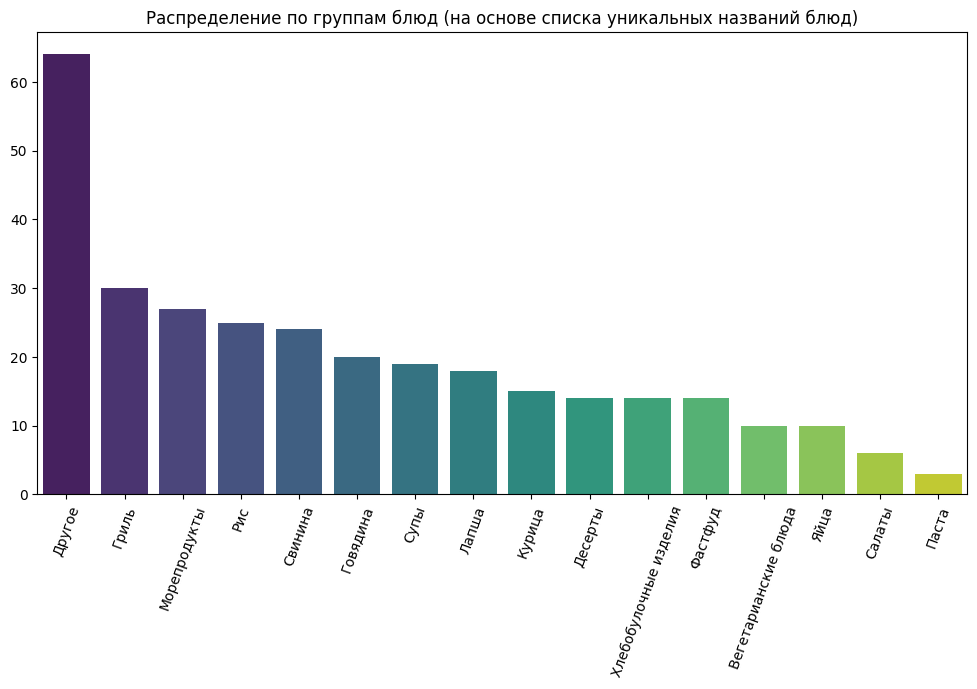

In [135]:
from collections import defaultdict

grouped_dishes_cnt = defaultdict(int)
for k, v in grouped_dishes.items():
    grouped_dishes_cnt[k] = len(list(v))

grouped_dishes_cnt_sorted = sorted(grouped_dishes_cnt.items(), key=lambda x: x[1], reverse=True)

x=[x[0] for x in grouped_dishes_cnt_sorted]
y=[x[1] for x in grouped_dishes_cnt_sorted]

plt.figure(figsize=(12, 6))
sns.barplot(x=x, y=y, palette="viridis")
plt.xticks(rotation=70)
plt.title('Распределение по группам блюд (на основе списка уникальных названий блюд)')
plt.show()

In [131]:
df['Другое'] # Визуально оценим специфичность названий из категории "Другое"

0                          bibimbap
1                        chip butty
2                          takoyaki
3                            gratin
4                sauteed vegetables
5                         croquette
6                              oden
7                         ganmodoki
8                            jiaozi
9                          sukiyaki
10                       nanbanzuke
11                     cabbage roll
12                            natto
13    kinpira-style sauteed burdock
14                    goya chanpuru
15                     almond jelly
16                        dak galbi
17                        kamameshi
18                           paella
19                           tanmen
20                        kushikatu
21                          champon
22                        chop suey
23                            samul
24                             zoni
25                       pot au feu
26                           namero
27                          

In [132]:
grouped_dishes['Рис']

['rice',
 'eels on rice',
 "chicken-'n'-egg on rice",
 'pork cutlet on rice',
 'chicken rice',
 'fried rice',
 'omelet with fried rice',
 'rice ball',
 'mixed rice',
 'rice vermicelli',
 'mushroom risotto',
 'rice gruel',
 'rice gratin',
 'minced pork rice',
 'glutinous oil rice',
 'boned, sliced Hainan-style chicken with marinated rice',
 'Barbecued red pork in sauce with rice',
 'Rice with roast duck',
 'Rice crispy pork',
 'Chicken Rice Curry With Coconut',
 'Hue beef rice vermicelli soup',
 'Steamed rice roll',
 'Small steamed savory rice pancake',
 'Glutinous Rice Balls',
 'eight treasure rice']

In [133]:
from collections import defaultdict

grouped_dishes_count = defaultdict(int)

for group, dishes in grouped_dishes.items():
    sum = 0
    for dish, count in category_count.items():
        if dish in list(dishes):
            sum += count
    grouped_dishes_count[group] += sum

grouped_dishes_count

defaultdict(int,
            {'Рис': 3517,
             'Лапша': 2399,
             'Супы': 2848,
             'Десерты': 1481,
             'Хлебобулочные изделия': 1608,
             'Салаты': 916,
             'Гриль': 3593,
             'Морепродукты': 3134,
             'Паста': 387,
             'Курица': 1688,
             'Свинина': 2763,
             'Говядина': 2459,
             'Вегетарианские блюда': 1161,
             'Яйца': 1150,
             'Фастфуд': 1829,
             'Другое': 7194})

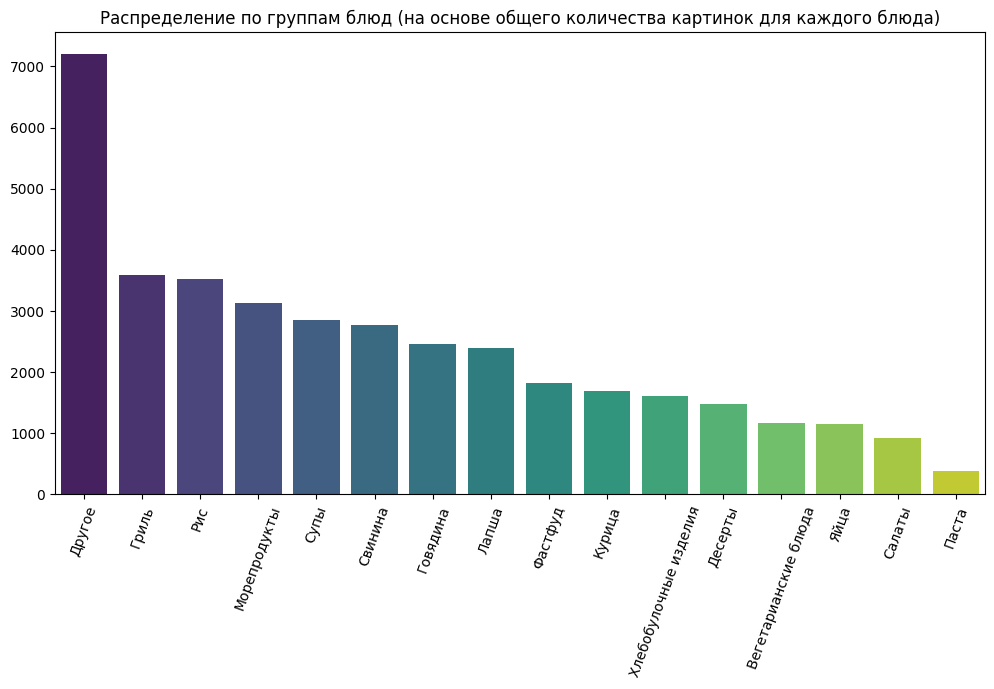

In [136]:
sorted_groups = sorted(grouped_dishes_count.items(), key=lambda x: x[1], reverse=True)

x=[x[0] for x in sorted_groups]
y=[x[1] for x in sorted_groups]

plt.figure(figsize=(12, 6))
sns.barplot(x=x, y=y, palette="viridis")
plt.xticks(rotation=70)
plt.title('Распределение по группам блюд (на основе общего количества картинок для каждого блюда)')
plt.show()